## Policy Gradient

On considère une politique paramétrée $\pi_\theta(a|s)$ et on cherche à maximiser

$J(\theta) = \mathbb{E}_{\tau \sim p_\theta(\tau)}[G(\tau)]$

où $\tau = (s_0,a_0,\dots,s_T)$ est une trajectoire et $p_\theta(\tau)$ sa probabilité sous la politique $\pi_\theta$.

On écrit explicitement :

$J(\theta) = \sum_\tau p_\theta(\tau) G(\tau)$

En dérivant :

$\nabla_\theta J(\theta) = \sum_\tau \nabla_\theta p_\theta(\tau) \, G(\tau)$

On utilise alors l'identité

$\nabla_\theta p_\theta(\tau) = p_\theta(\tau)\,\nabla_\theta \log p_\theta(\tau)$

ce qui donne

$\nabla_\theta J(\theta) = \sum_\tau p_\theta(\tau)\,\nabla_\theta \log p_\theta(\tau)\,G(\tau)$

soit sous forme d'espérance

$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim p_\theta(\tau)}\big[ \nabla_\theta \log p_\theta(\tau)\, G(\tau) \big]$

Or la dynamique de l'environnement ne dépend pas de $\theta$ et il y a indépendances à chaque instants, donc

$\log p_\theta(\tau) = \sum_{t=0}^T \log \pi_\theta(a_t|s_t) + \text{constante}$

et donc

$\nabla_\theta \log p_\theta(\tau) = \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t)$

Finalement,

$\nabla_\theta J(\theta) = \mathbb{E}\left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t)\, G(\tau) \right]$

En pratique on remplace $G(\tau)$ par le retour à partir de $t$, noté $G_t$, ce qui conduit à l'algorithme REINFORCE.

On peut par la suite mettre à jour $\theta$ avec une descente de gradient. 

In [58]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [59]:
env = gym.make("FrozenLake-v1", is_slippery=True)

n_states = env.observation_space.n
n_actions = env.action_space.n

gamma = 0.99 # facteur de discount, plus il est proche de 1, plus l'agent valorise 
# les récompenses futures
alpha = 0.01 # taux d'apprentissage, plus il est élevé, plus l'agent apprend rapidement,
# mais peut aussi, utilisé dans le gradient de la politique
n_episodes = 100000
batch_size = 10  # nombre de trajectoires par update

In [60]:
theta = np.zeros((n_states, n_actions)) # paramètres de la politique, initialisés à zéro, 
# qui seront mis à jour pendant l'apprentissage

def softmax(x): # fonction d'activation qui transforme les paramètres de la politique 
    # en probabilités d'action
    z = x - np.max(x)  
    exp = np.exp(z)
    return exp / np.sum(exp)

def get_action(s): # fonction qui retourne une action en fonction de l'état actuel, 
    # en utilisant la politique définie par les paramètres theta et la fonction softmax
    probs = softmax(theta[s])
    return np.random.choice(n_actions, p=probs)

In [61]:
def compute_returns(rewards, gamma): # fonction qui calcule les retours (returns)
    #  à partir des récompenses obtenues pendant un épisode
    G = 0
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns

In [62]:
episode_rewards = []

for episode in range(n_episodes):

    states = []
    actions = []
    rewards = []

    s, _ = env.reset()
    done = False

    while not done:
        a = get_action(s) # on choisit une action en fonction de la politique actuelle
        s_next, r, terminated, truncated, _ = env.step(a) # on exécute l'action et on 
        # observe la récompense et le nouvel état
        done = terminated or truncated

        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = s_next

    returns = compute_returns(rewards, gamma) #on a simulé une trajectoire tau à partir 
    # d'une politique et on a obtenu les récompenses, on calcule les retours à partir 
    # de ces récompenses. On va pouvoi mettre à jour la politique en utilisant ces retours. 

    for t in range(len(states)):
        s = states[t]
        a = actions[t]
        Gt = returns[t]

        probs = softmax(theta[s]) # on calcule les probabilités d'action 
        # à partir des paramètres de la politique dans l'état s

        grad = -probs # gradient de la politique pour toutes les actions pour 
        # une proba softmax, on soustrait 1 à la proba de l'action choisie
        grad[a] += 1

        # aller voir la fin du notebook pour voir le calcul

        theta[s] += alpha * Gt * grad #mise à jour des paramètres de la politique en utilisant 
        # le gradient et le retour

    episode_rewards.append(sum(rewards))

In [63]:
def moving_average(x, window=1000):
    return np.convolve(x, np.ones(window)/window, mode='valid')

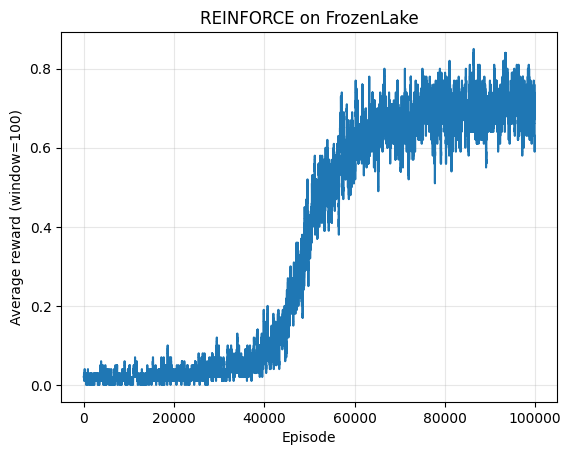

In [64]:
window = 100
plt.plot(moving_average(episode_rewards, window))
plt.grid(alpha=0.3)
plt.xlabel("Episode")
plt.ylabel("Average reward (window={})".format(window))
plt.title("REINFORCE on FrozenLake")
plt.show()

Dans l’implémentation précédente, l’espérance théorique du gradient est estimée à partir d’une seule trajectoire simulée. On utilise donc un unique échantillon pour approximer cette espérance, ce qui correspond à une estimation Monte Carlo bruitée.

Il serait également possible d’estimer cette espérance en moyennant le gradient sur plusieurs trajectoires avant d’effectuer la mise à jour. Cela permettrait d’obtenir une estimation plus stable, au prix d’un calcul plus coûteux par itération.

Sur FrozenLake, les performances du policy gradient restent modestes. L’environnement présente une récompense très sparse et une dynamique stochastique (slippery), ce qui rend l’estimation du gradient particulièrement bruitée. Même en utilisant plusieurs trajectoires par mise à jour, la variance demeure élevée et la convergence lente.

Comparé aux méthodes basées sur la valeur comme Q-learning, le policy gradient pur (REINFORCE) apparaît moins efficace dans ce cadre discret et de petite dimension. Cela illustre une limite pratique des méthodes Monte Carlo sans baseline ni critic : elles sont théoriquement correctes mais souvent peu performantes dans des environnements simples et bruités.

Cette observation motive l’introduction de variantes plus stables, comme REINFORCE avec baseline ou les méthodes Actor-Critic.

## Actor-Critic et rôle du Critic

Dans REINFORCE, la mise à jour de la politique repose directement sur le retour total obtenu après une trajectoire. Cette estimation est non biaisée mais présente une variance élevée, ce qui rend l’apprentissage instable.

L’idée d’Actor-Critic est d’introduire un **Critic**, c’est-à-dire une fonction de valeur $V(s)$ apprise, qui estime le retour attendu à partir d’un état donné.

Au lieu d’utiliser directement le retour total, on utilise une erreur temporelle (TD error) :

$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$

Cette quantité mesure si l’action effectuée a été meilleure ou pire que ce qui était prévu par le Critic.

Le Critic met à jour $V(s)$ pour améliorer son estimation.  
L’Actor met à jour la politique en utilisant $\delta_t$ comme signal :

- si $\delta_t > 0$, l’action était meilleure que prévu → on augmente sa probabilité  
- si $\delta_t < 0$, elle était moins bonne que prévu → on diminue sa probabilité  

Ainsi, le Critic réduit la variance du signal d’apprentissage et stabilise l’entraînement, tout en conservant une estimation non biaisée du gradient en moyenne.

Actor = décide  
Critic = évalue  

In [ ]:
theta = np.zeros((n_states, n_actions))  # initialisation des paramètres de la politique à zéro
V = np.zeros(n_states)                  # initialisation des valeurs d'état à zéro

alpha_actor = 0.01 # taux d'apprentissage pour l'acteur, utilisé dans la mise à jour 
# des paramètres de la politique
alpha_critic = 0.1 # taux d'apprentissage pour le critique, utilisé dans la mise à jour 
# des valeurs d'état

episode_rewards = []

for episode in range(n_episodes):

    s, _ = env.reset()
    done = False
    total_reward = 0

    while not done:

        a = get_action(s)
        s_next, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        total_reward += r

        #  Critic 
        td_target = r + gamma * V[s_next] * (1 - done) # cible pour la mise à jour du critique,
        # qui est la récompense immédiate plus la valeur de l'état suivant,
        # pondérée par le facteur de discount et ajustée pour les épisodes terminés
        td_error = td_target - V[s] # erreur temporelle, qui mesure l'écart entre la cible 
        # et la valeur actuelle de l'état

        V[s] += alpha_critic * td_error
        # mise à jour des valeurs d'état en utilisant l'erreur temporelle 
        # et le taux d'apprentissage du critique

        #  Actor 
        probs = softmax(theta[s]) # on calcule les probabilités d'action à partir des 
        # paramètres de la politique dans l'état s
        grad = -probs
        grad[a] += 1

        theta[s] += alpha_actor * td_error * grad

        s = s_next

    episode_rewards.append(total_reward)

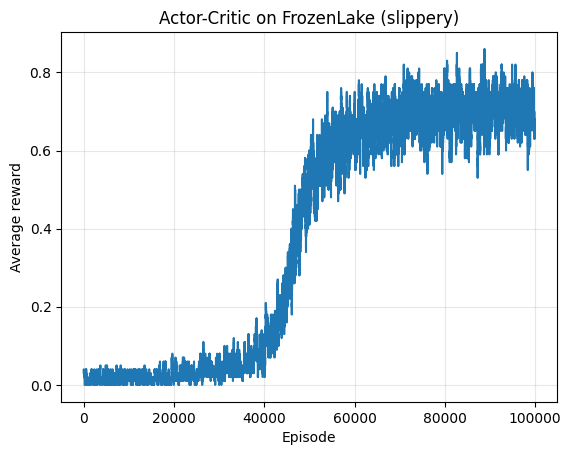

In [72]:
plt.plot(moving_average(episode_rewards, window))
plt.grid(alpha=0.3)
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.title("Actor-Critic on FrozenLake (slippery)")
plt.show()

## Différence entre version tabulaire et version avec features

Dans la version tabulaire, chaque couple (s, a) possède son propre paramètre indépendant. La politique est donc représentée par une simple table de taille n_states × n_actions, sans partage d’information entre les états.

Dans la version avec features, la politique est paramétrée par un vecteur global θ et une représentation φ(s, a). Le score associé à une action est donné par un produit scalaire θ · φ(s, a). 

Lorsque φ(s, a) est un vecteur one-hot, cette formulation est strictement équivalente à la version tabulaire : chaque paramètre correspond encore à un unique couple (s, a).

Cependant, la formulation avec features devient intéressante lorsque φ(s, a) contient des caractéristiques plus générales de l’état et de l’action. Dans ce cas, les paramètres sont partagés entre plusieurs états, ce qui permet la généralisation et l’approximation de fonctions dans des espaces plus complexes.

In [73]:
def phi(s, a):
    vec = np.zeros(n_states * n_actions)
    index = s * n_actions + a
    vec[index] = 1.0
    return vec

In [74]:
def get_logits(s):
    logits = np.zeros(n_actions)
    for a in range(n_actions):
        logits[a] = theta @ phi(s, a)
    return logits

def softmax(x):
    z = x - np.max(x)
    exp = np.exp(z)
    return exp / np.sum(exp)

def get_action(s):
    logits = get_logits(s)
    probs = softmax(logits)
    return np.random.choice(n_actions, p=probs)

In [75]:
episode_rewards = []
theta = np.zeros(n_states * n_actions)  # initialisation des paramètres de la politique à zéro

for episode in range(n_episodes):

    states = []
    actions = []
    rewards = []

    s, _ = env.reset()
    done = False

    while not done:
        a = get_action(s)
        s_next, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = s_next

    # calcul des retours
    G = 0
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    # mise à jour
    for t in range(len(states)):
        s = states[t]
        a = actions[t]
        Gt = returns[t]

        logits = get_logits(s)
        probs = softmax(logits)

        # gradient théorique :
        # phi(s,a) - sum_a' pi(a'|s) phi(s,a')

        grad = phi(s, a)

        expected_phi = np.zeros_like(theta)
        for a_prime in range(n_actions):
            expected_phi += probs[a_prime] * phi(s, a_prime)

        grad -= expected_phi

        theta += alpha * Gt * grad

    episode_rewards.append(sum(rewards))

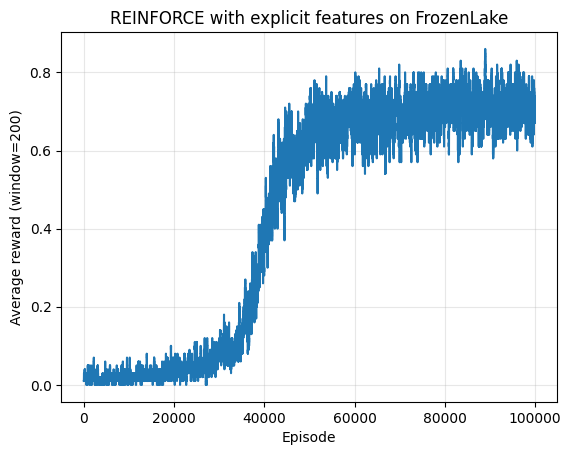

In [76]:
plt.plot(moving_average(episode_rewards, window))
plt.grid(alpha=0.3)
plt.xlabel("Episode")
plt.ylabel("Average reward (window=200)")
plt.title("REINFORCE with explicit features on FrozenLake")
plt.show()

## Gradient du log-softmax (appendice)

On fixe un état $s$ et on note $\theta_a := \theta_{s,a}$.

La politique softmax est définie par :

$\pi(a) = \frac{e^{\theta_a}}{\sum_b e^{\theta_b}}$

On note $Z = \sum_b e^{\theta_b}$, donc :

$\pi(a) = \frac{e^{\theta_a}}{Z}$

On prend le logarithme :

$\log \pi(a) = \theta_a - \log Z$

On dérive par rapport à un paramètre $\theta_k $ :

$\frac{\partial}{\partial \theta_k} \log \pi(a) =
\frac{\partial}{\partial \theta_k} \theta_a-
\frac{\partial}{\partial \theta_k} \log Z$

Premier terme :

$\frac{\partial}{\partial \theta_k} \theta_a=
\begin{cases}
1 & \text{si } k=a \\
0 & \text{sinon}
\end{cases}$

Deuxième terme :

$\frac{\partial Z}{\partial \theta_k} = e^{\theta_k}$

Donc

$\frac{\partial}{\partial \theta_k} \log Z=
\frac{1}{Z} e^{\theta_k}=
\pi(k)$

En combinant :

Si $k = a$ :

$\frac{\partial}{\partial \theta_a} \log \pi(a) = 1 - \pi(a)$

Si $k \neq a$ :

$\frac{\partial}{\partial \theta_k} \log \pi(a) = -\pi(k)$

